https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras import backend as K
from keras import initializers
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
K.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
tr_im = np.loadtxt("reals.dat")

In [3]:
tr_im.shape

(20000, 4000)

In [4]:
nrow,ncol = 80,50

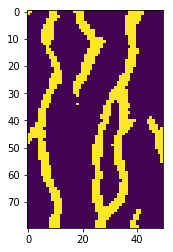

In [5]:
plt.imshow(tr_im[0,:].reshape((nrow,ncol)))

In [6]:
npar = 200 #number of standard normal deviates to feed to generator input

In [7]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
optg = Adam(lr=0.0001,beta_1=0.5)
optd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [8]:
tr_im.max(),tr_im.min()

(1.0, 0.0)

In [9]:
generator = Sequential()
generator.add(Dense(npar*8*5, input_shape=(npar,), kernel_initializer=keras.initializers.RandomNormal(stddev=0.002)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((npar, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=optg)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8000)              1608000   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8000)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 8, 5)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 16, 10)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 16, 10)       1280256   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 16, 10)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 16, 10)       819328    
__________

In [10]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(mean=0.5,stddev=0.002)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.35))
discriminator.add(Conv2D(256, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(512, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optd)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 40, 25)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 40, 25)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 40, 25)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 20, 13)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 20, 13)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 10, 7)        819456    
__________

#tensorboard code
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()
log_path = './logs'
callback = TensorBoard(log_path)
callback.set_model(gan)



In [11]:
discriminator.trainable = False
gi = Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=optg)

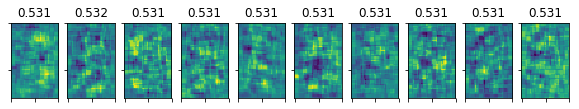

In [12]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    #print(vecs[0,:])
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

78


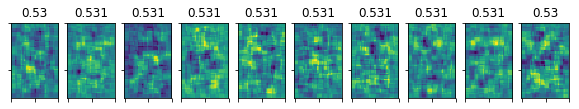

0 0.7796346 0.4302185226 0.4392051


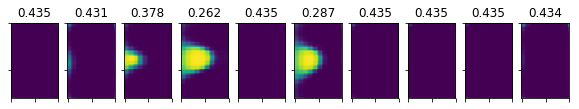

1 1.1758598 0.3976489337 0.36677015


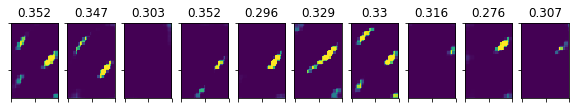

2 1.8125478 0.6299503445


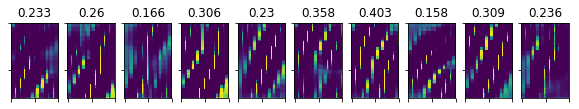

3 2.2211366 0.63881355560.66675127


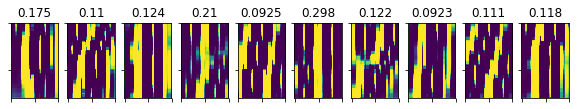

4 1.2208189 0.53815633970.53328824


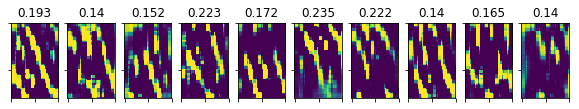

5 1.1845441 0.4901674777


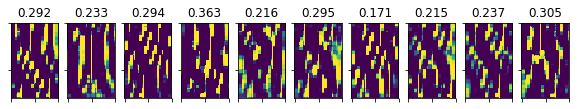

6 0.9674941 0.4514717883


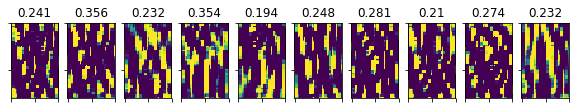

7 0.8352675 0.4823435224


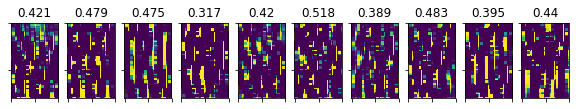

8 1.6505787 0.4645345552


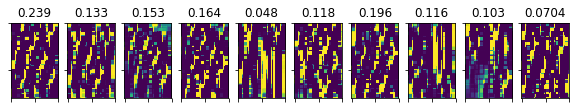

9 1.1328758 0.4155099946


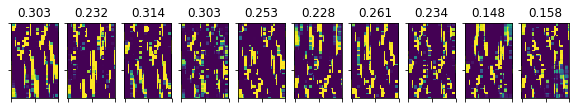

10 1.0184522 0.404844528


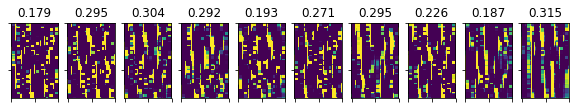

11 1.6365639 0.307318036


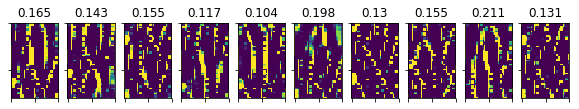

12 2.305112 0.3479017374.3484415


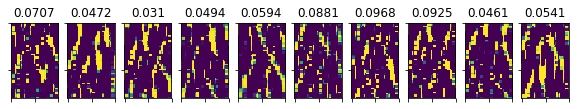

13 1.7743744 0.31825277


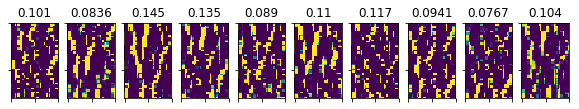

14 2.9372344 0.336027263


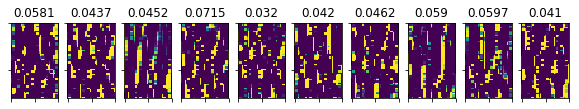

15 1.5580074 0.32541284


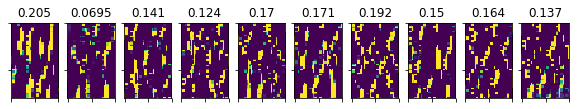

16 2.528314 0.279222955


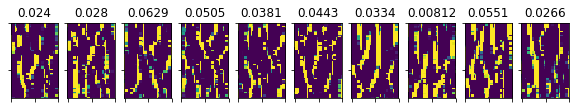

17 2.0183508 0.28098727


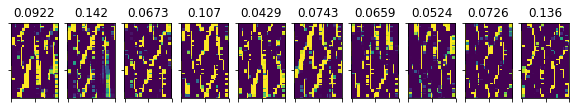

18 3.0199354 0.316409140.30522025


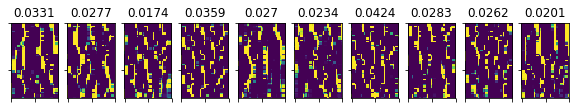

19 3.273904 0.318339658


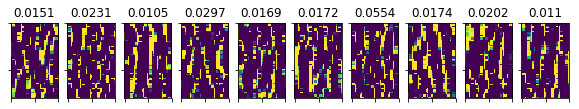

20 2.76401 0.26885036944.057475 0.35685137


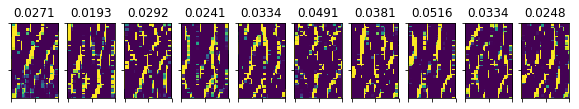

21 2.6645546 0.27753928


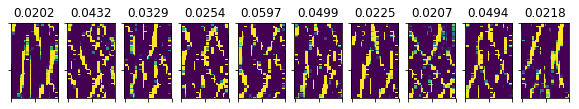

22 1.9226886 0.29607233.25634176


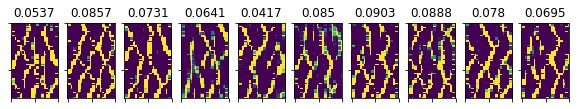

23 2.7877188 0.26553217


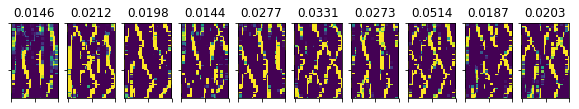

24 2.8282435 0.24435462


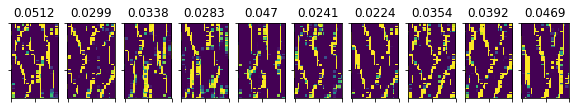

25 2.5583344 0.261844920.3265206


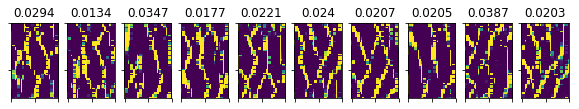

26 2.735537 0.2755013420.2681877


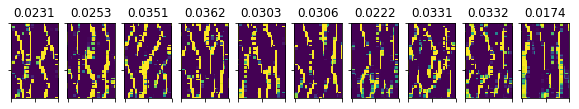

27 2.7378793 0.251261980.26806632


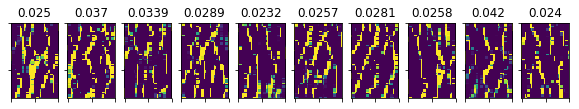

28 2.6908143 0.246435910.26337522


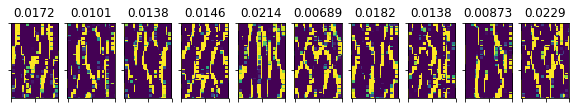

29 2.8280468 0.253584770.287974


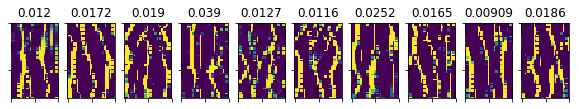

30 2.4212878 0.24909455


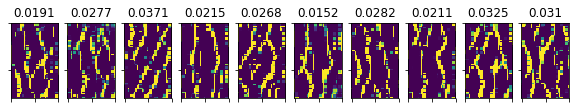

31 2.7109828 0.240787120.24267921


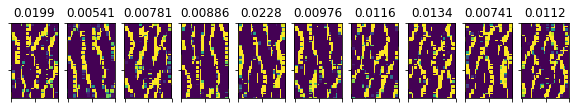

32 2.8918974 0.23943194


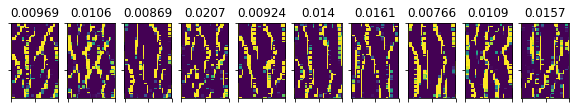

33 2.3832288 0.25366345 2.3832288 0.25366345


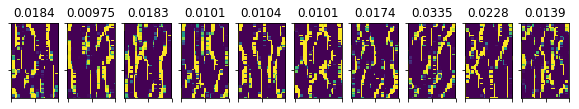

34 3.0678256 0.249666350.23931275 0.26874036


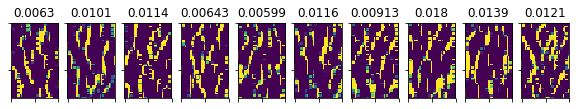

35 3.0394642 0.24556176


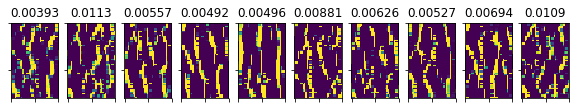

36 3.2553666 0.24213317


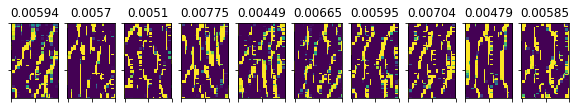

37 2.9399006 0.234341340.24149065


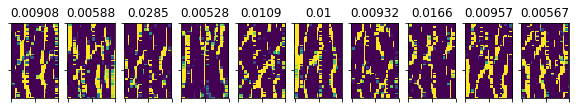

38 3.0949447 0.24922633


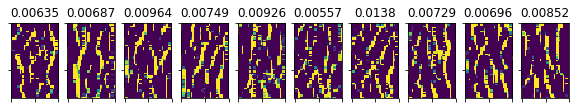

39 3.1261733 0.23220007 3.1261733 0.23220007


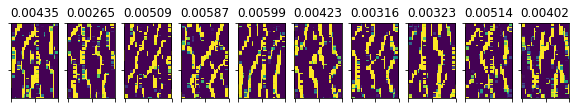

40 2.7937489 0.25133121.22861259


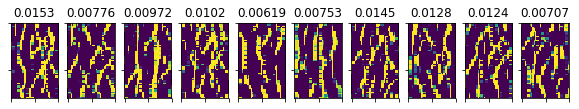

41 3.0072799 0.24778277


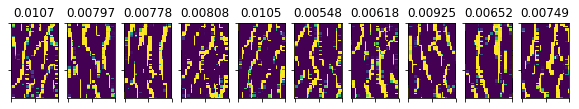

42 3.2701719 0.25172457


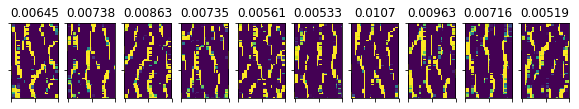

43 3.0097282 0.23833227


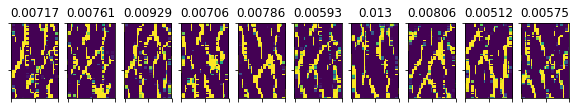

44 3.1711993 0.23297432


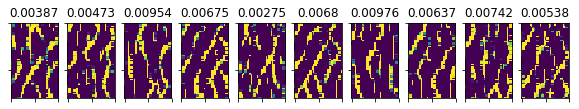

45 3.081654 0.225988451 3.081654 0.22598845


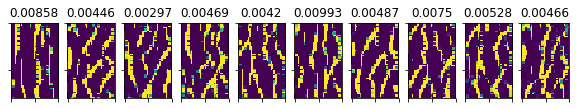

46 2.973105 0.231270188


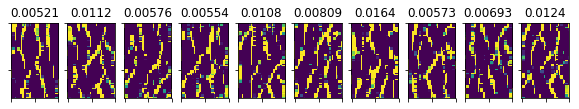

47 2.739467 0.251362448


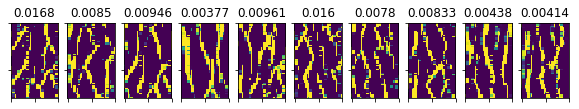

48 3.3573656 0.24416469


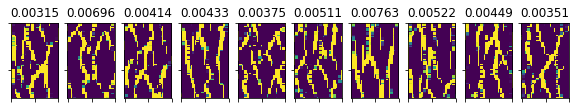

49 2.7784235 0.23004675


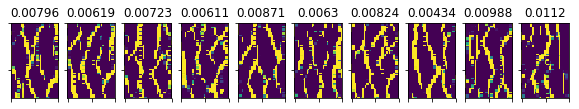

50 2.9644368 0.23411222 0.22551934 3.1209185 0.23524006


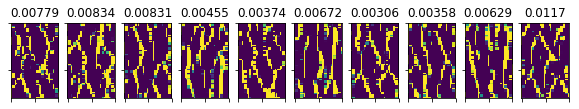

51 2.9112813 0.23559155


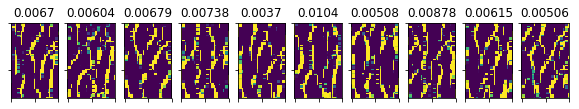

52 2.7291944 0.239886160.23988616


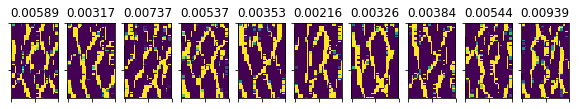

53 2.5449362 0.23563945


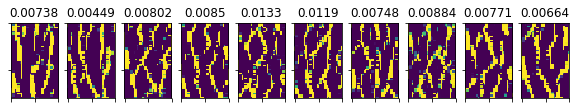

54 2.8115244 0.23393069.244624470.23523820.23873028


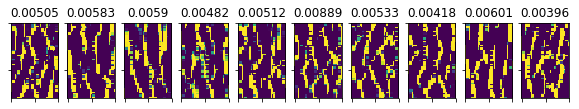

55 2.952364 0.2238851570.233390390.22400746


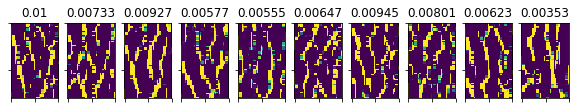

56 2.6299045 0.22090426


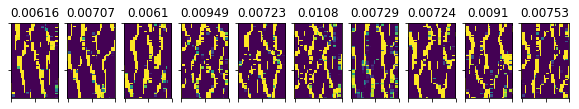

57 2.634799 0.224341288


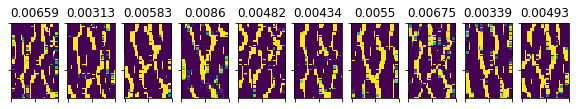

58 3.726172 0.242945855


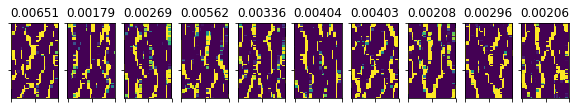

59 2.8053076 0.226243020.2381841


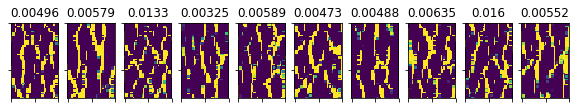

60 2.8672714 0.24187227


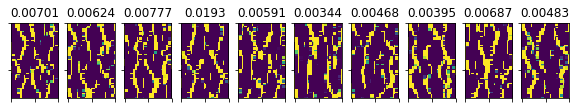

61 3.1342623 0.23619865


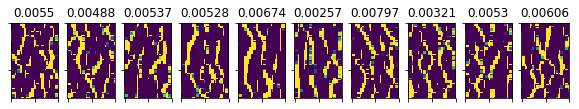

62 3.213025 0.221655884


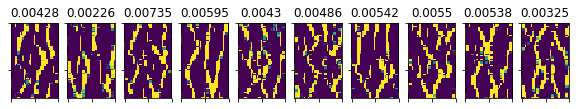

63 3.0517588 0.22341308


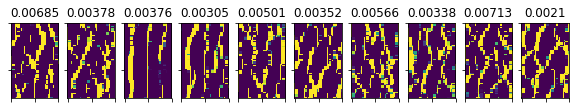

64 3.1993976 0.23446825


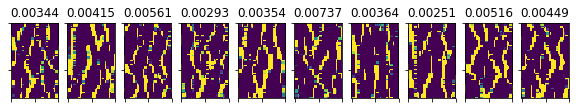

65 3.072053 0.225941752


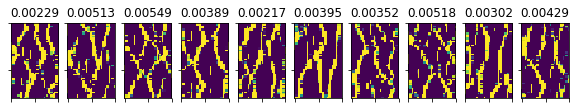

66 2.864653 0.230698624.228626150.23587745


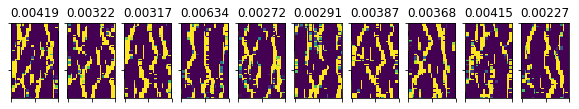

67 2.6973429 0.23523359


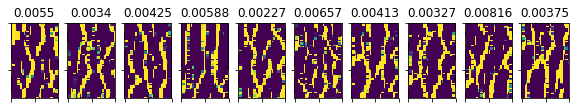

68 2.7909365 0.23056665


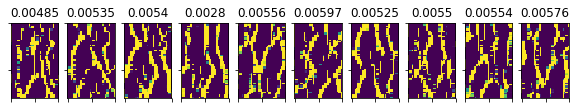

69 2.4109294 0.25125977


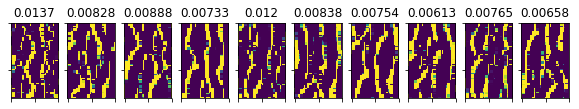

70 2.9759274 0.23712575


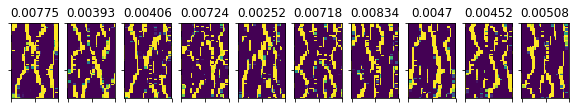

71 2.954029 0.216993237


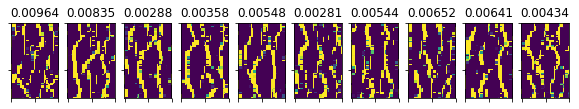

72 3.128274 0.2259206552.6693435 0.23578313


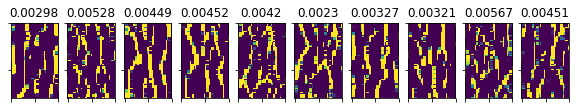

73 2.941728 0.225240023 2.960524 0.22894494


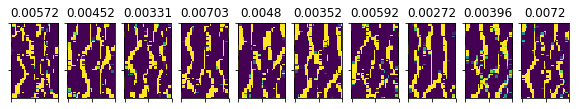

74 3.0264046 0.23323955


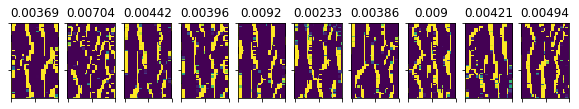

75 3.3126562 0.23655245


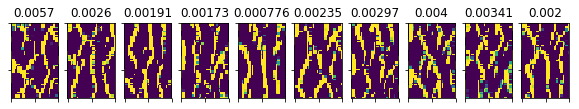

76 3.034071 0.221946634


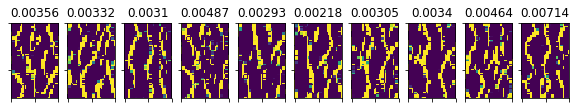

77 3.291007 0.242638281


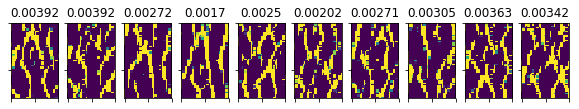

78 2.885091 0.225872254


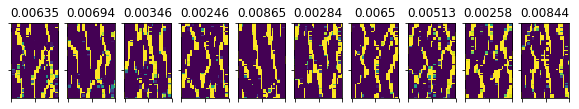

79 2.9839563 0.21982601


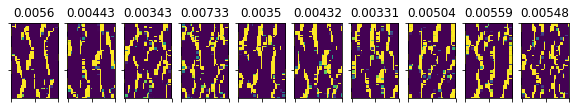

80 2.908122 0.2215756510.23291871 3.298779 0.22114737 2.908122 0.22157565


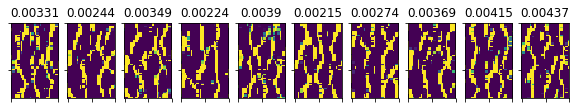

81 3.1422005 0.226368040.22738841


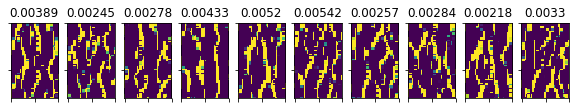

82 3.287571 0.234680941


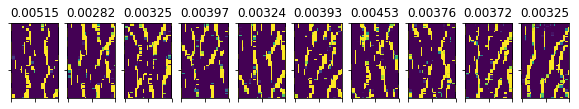

83 2.717042 0.234611546


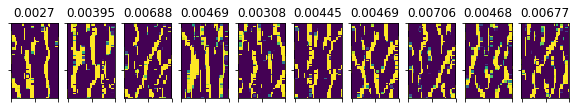

84 2.7499826 0.22587486


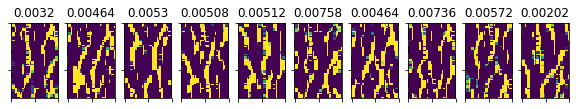

85 2.9359708 0.22358387


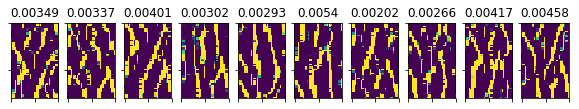

86 2.520793 0.231386141


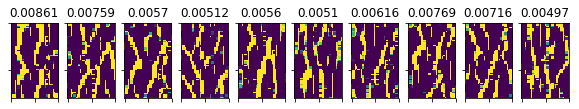

87 3.0373812 0.232126640.238132580.23718855


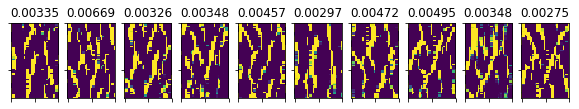

88 2.9373872 0.22929274


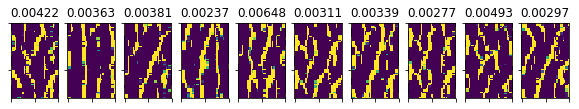

89 3.0514452 0.22672811


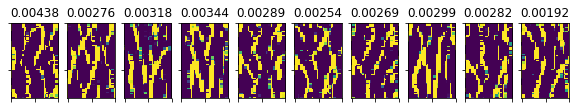

90 2.9781368 0.224835350.22161971


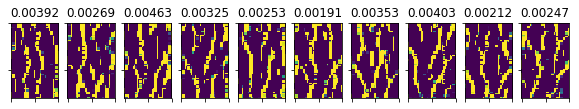

91 2.7849994 0.22461122


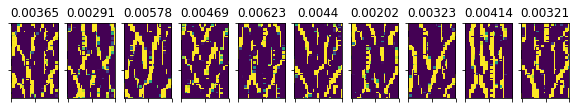

92 3.068152 0.231707627


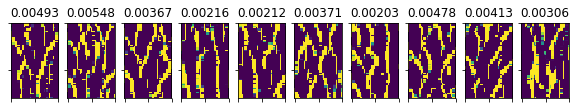

93 2.7241461 0.22406653


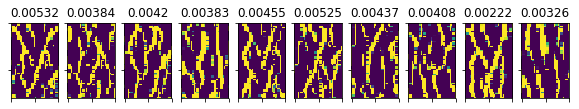

94 2.9490852 0.221767110.22739619


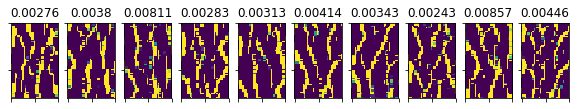

95 3.1353815 0.22635077


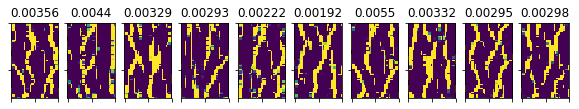

96 2.6936033 0.222298830.23098333


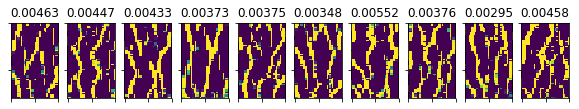

97 2.891769 0.2306955250.221286060.21859667


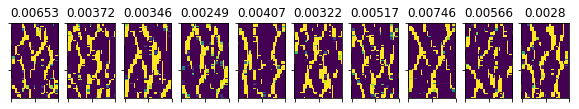

98 3.008295 0.234657337


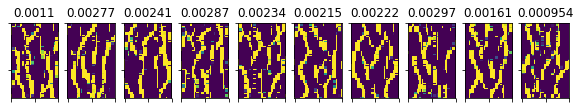

99 2.6068244 0.224546310.21770953.0169194 0.2298275


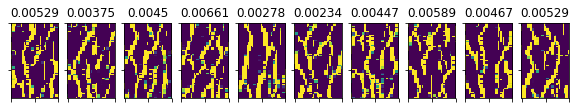

100 3.0759983 0.22424605


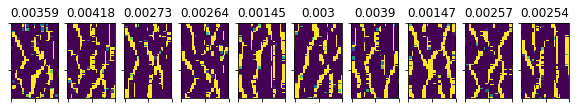

101 2.8948429 0.2288781


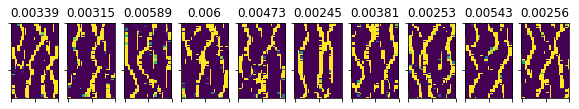

1022.7814174 0.21211608 2.7814174 0.21211608


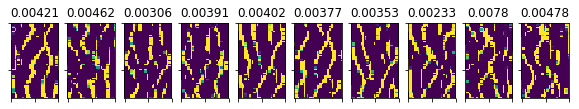

103 2.9458303 0.21822879


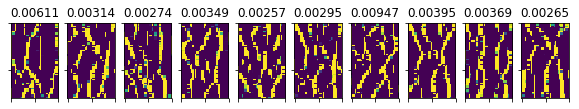

104 3.2422419 0.23093721.21355242


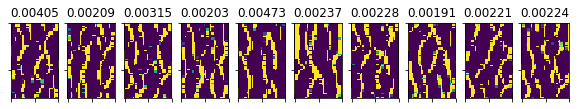

105 3.0533469 0.2236053


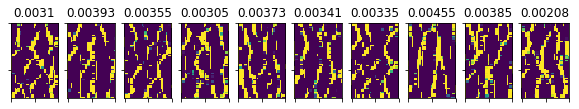

106 3.1451774 0.23455322


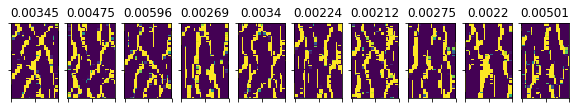

107 2.8277857 0.21746393


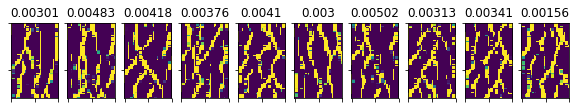

108 3.0793917 0.22927484


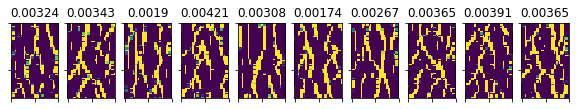

109 2.9438355 0.2239113


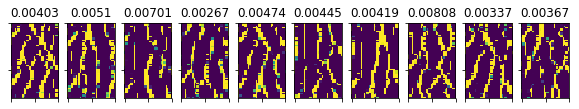

110 2.8532782 0.22424014


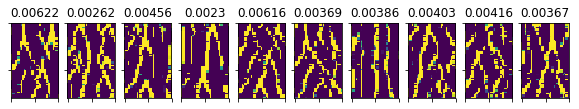

111 3.2635472 0.21580102


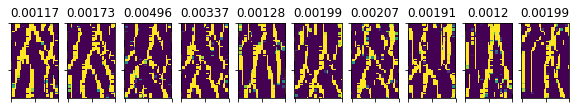

112 3.120495 0.22740494


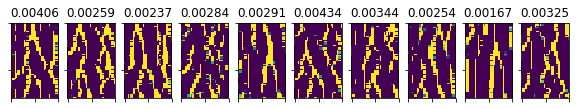

113 2.7209575 0.2406255


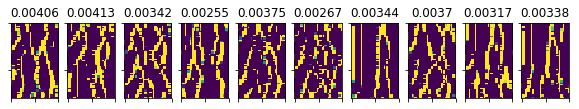

114 2.909646 0.22460695


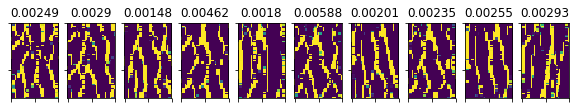

115 2.7598622 0.23903950.22567582


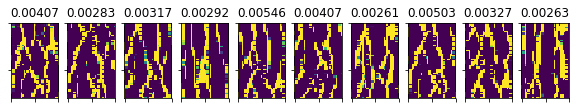

116 2.8523586 0.22632888


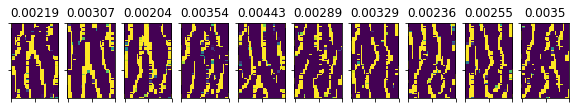

117 2.960637 0.22547214


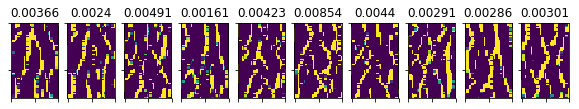

118 2.5909643 0.22476988.21920471


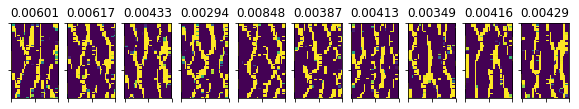

1192.7416115 0.220449982.7662501 0.22994852 2.7416115 0.22044998


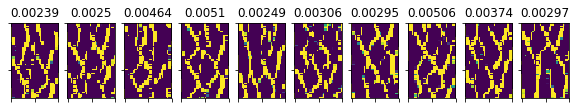

120 2.9032912 0.2176832


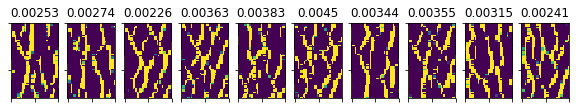

121 3.1215246 0.21565631


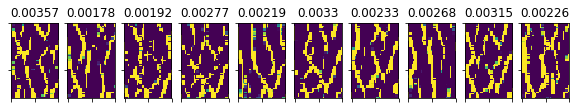

122 3.0766318 0.23485073


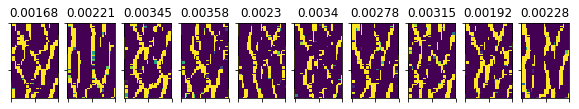

123 2.8902361 0.209081892.8073895 0.22411145


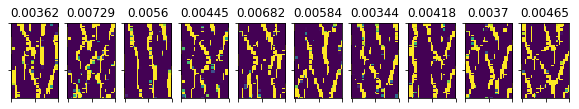

1242.8599834 0.22700614 2.8599834 0.22700614


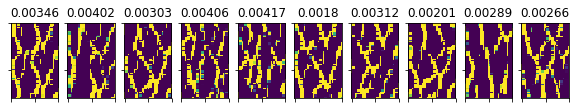

125 3.1394858 0.22300245


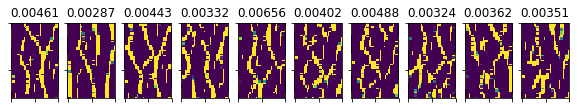

126 2.9787273 0.21046019


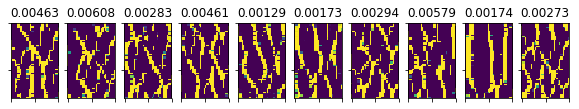

127 3.1688306 0.22317527


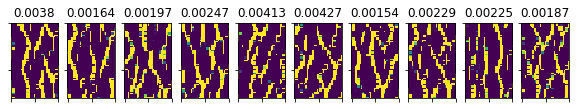

128 3.0389948 0.21263678


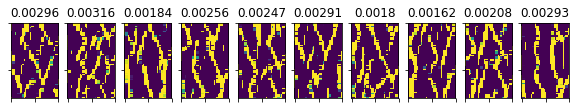

129 2.897777 0.21941263


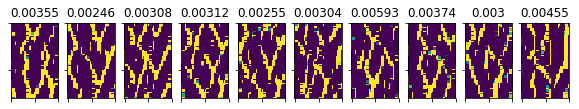

130 3.0327654 0.22450566


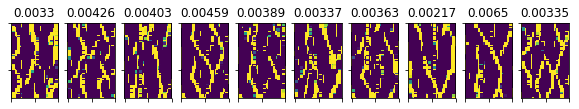

131 3.1714525 0.22112557


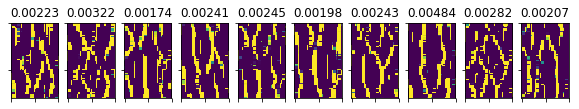

132 2.7765121 0.22048675


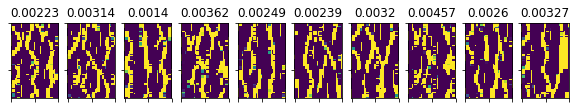

133 3.0327754 0.22076313


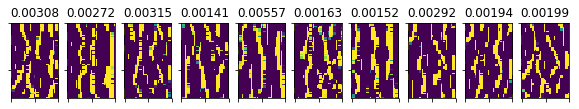

134 3.007677 0.21868838


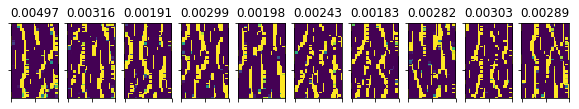

135 2.913125 0.22273092


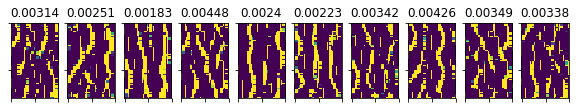

136 3.188697 0.21139589


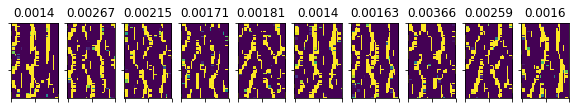

137 3.0099695 0.23021154


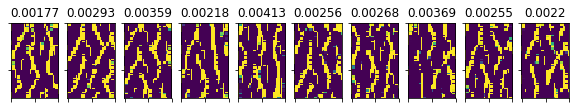

138 3.171068 0.23135163


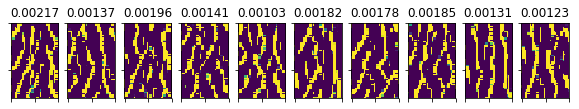

139 3.0491948 0.21840736


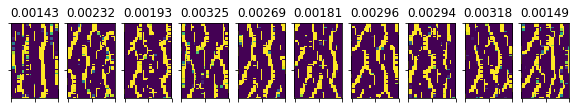

140 2.9506924 0.21978033


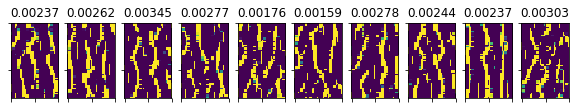

141 3.1642168 0.2201342


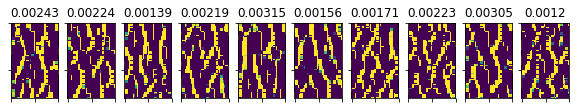

142 3.0638978 0.22061722


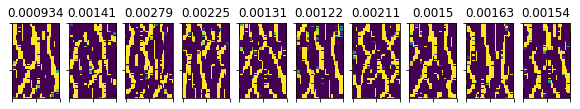

143 3.157136 0.21404226


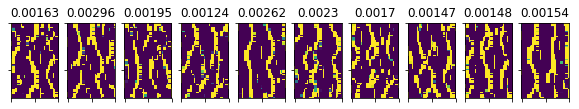

144 3.2154472 0.22282292


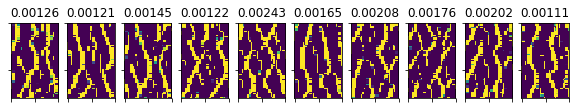

145 2.6595054 0.22354048.21864149


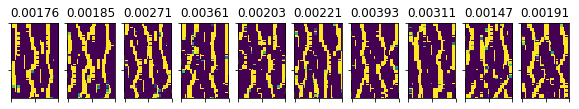

1462.8489978 0.21827975 2.8489978 0.21827975


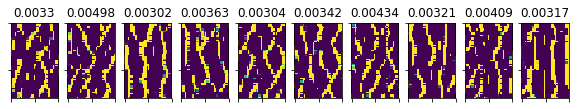

147 3.1485114 0.21984385


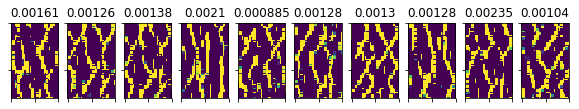

1482.7046564 0.22307983 2.7046564 0.22307983


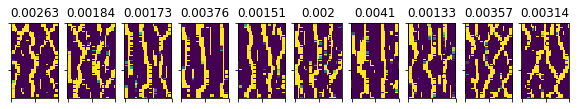

149 2.8632958 0.22265309


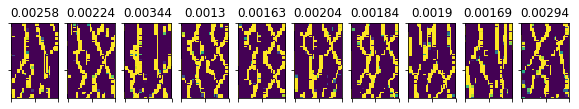

150 3.2090878 0.21698809


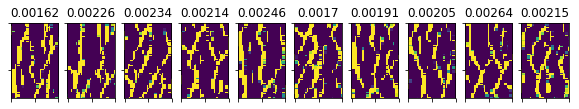

151 2.911673 0.22212494


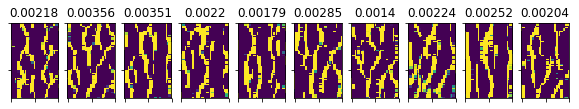

152 2.991177 0.21791974


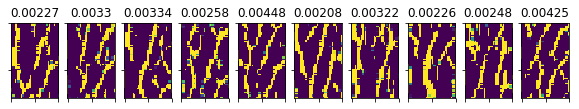

153 2.9124455 0.22108242


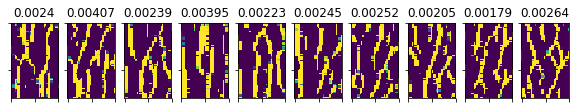

154 2.9860504 0.22989350.21343479


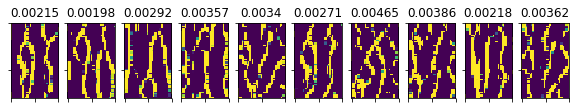

155 3.085829 0.21519911


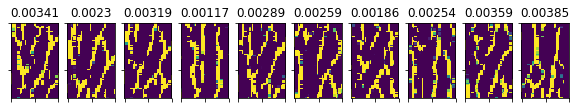

156 3.0726056 0.22535317


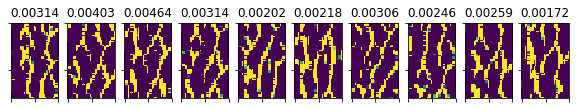

157 2.6657844 0.22574446.21075153


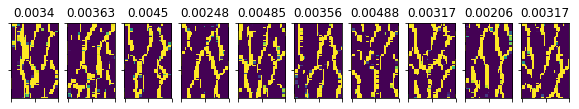

158 3.0957274 0.22125907.2136867


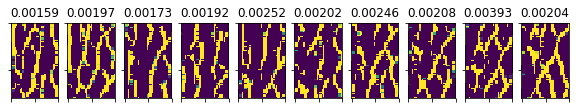

159 3.0112875 0.22981471


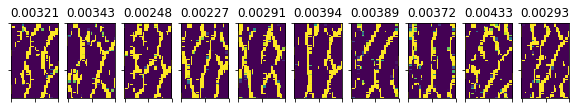

160 3.1354442 0.22688167


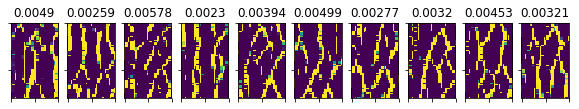

161 2.9082158 0.21235074.2298286


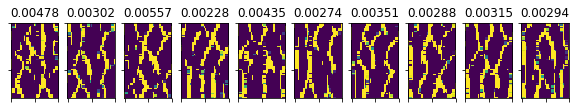

162 2.7830195 0.22001116


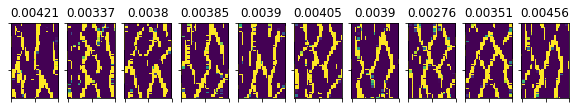

163 3.052455 0.21673755


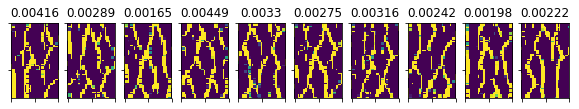

164 2.9128914 0.22764167.21431546


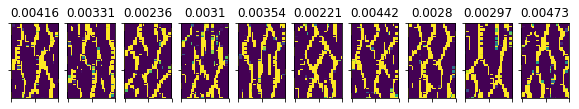

165 2.9714136 0.21387655


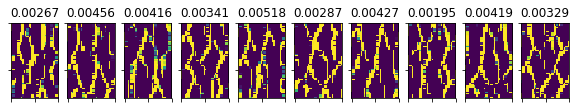

166 2.8553271 0.21705121


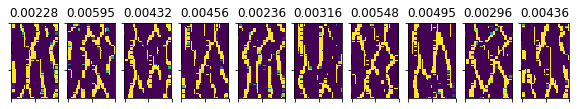

167 2.8412342 0.22130299


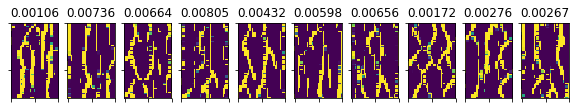

168 2.768784 0.22377832


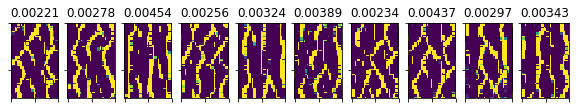

169 2.7764554 0.21642748


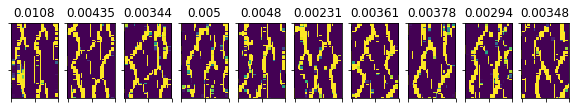

170 2.7353387 0.21956736


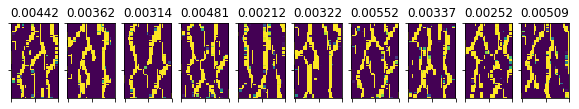

171 3.0241714 0.22381978


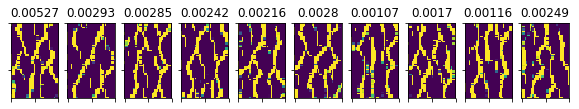

172 2.9498897 0.22122385


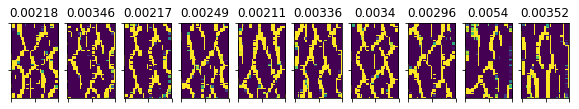

173 3.0073142 0.21920094


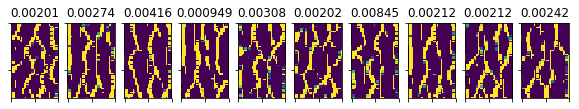

174 2.8950558 0.21812335.21689999


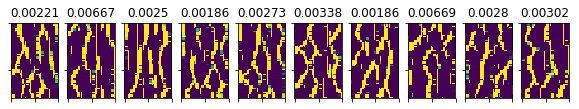

175 2.9585464 0.21411537


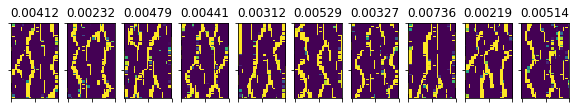

176 2.8273792 0.22538579


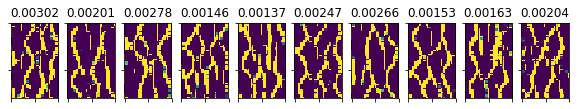

177 2.9174063 0.21591409


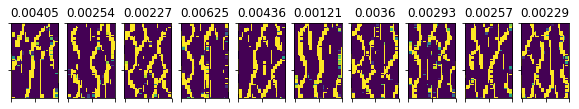

178 2.8786447 0.21736094


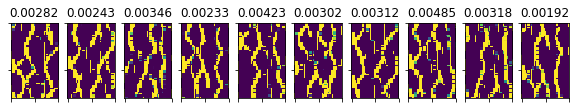

179 2.7848067 0.22809696


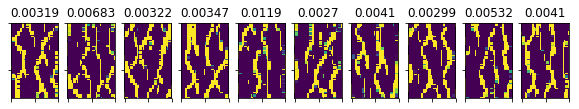

180 3.003551 0.21092184.9276223 0.22004464


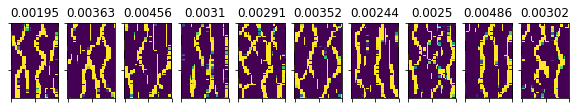

181 3.014282 0.222344790.22569741


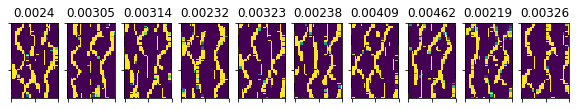

182 2.8247726 0.21463351.2191014


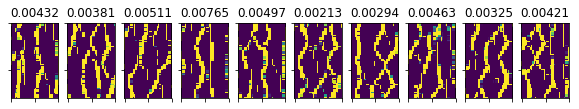

183 2.9692326 0.21682958


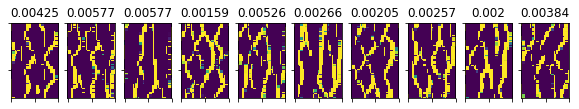

184 2.8696249 0.21611492


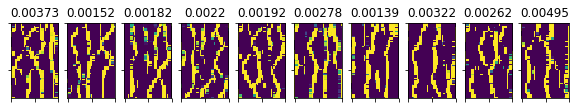

185 3.0585852 0.21800378


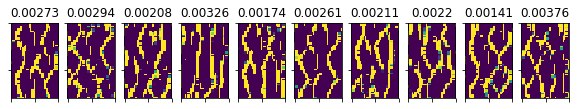

186 2.76915 0.212474668


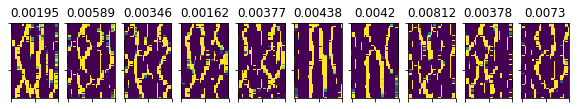

187 2.779748 0.221092640.22103506


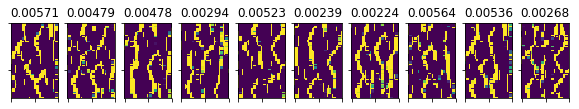

188 2.8250258 0.21609654.2126397


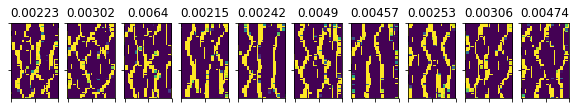

189 2.822272 0.22783214


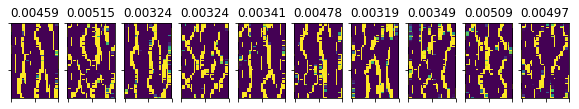

190 3.0953112 0.23448324


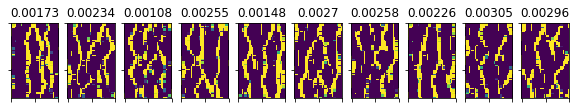

191 2.9452205 0.20978174


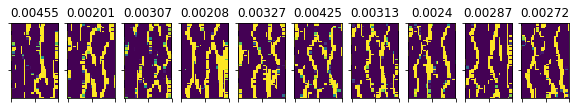

192 2.779426 0.22353634


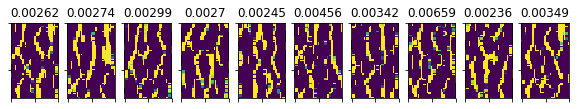

193 2.996066 0.22323358


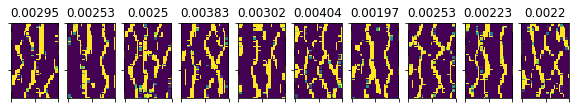

194 3.0333664 0.22479019


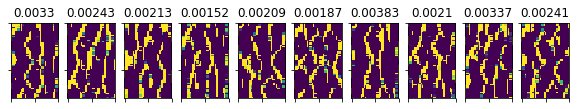

195 3.0370412 0.21261999


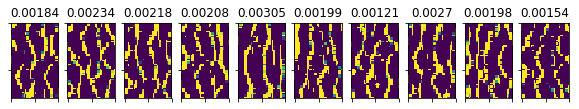

196 2.8181133 0.22473982


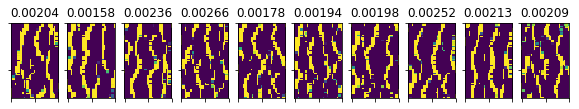

197 2.905463 0.20921865


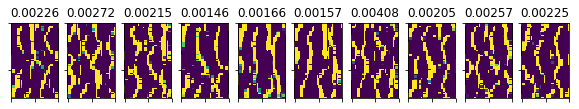

198 3.109471 0.218416242.9552643 0.22391123


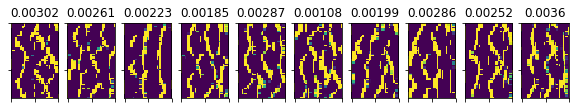

199 3.0221548 0.22392523.21871419


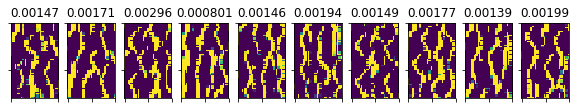

200 3.038624 0.21682015


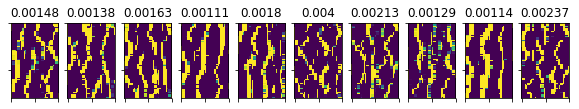

201 3.0169191 0.221199660.21988437


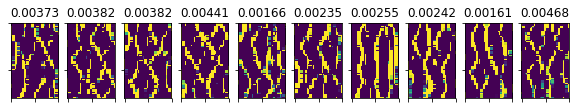

202 2.9301264 0.21353261


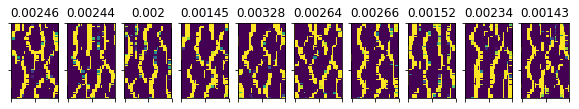

203 2.8655314 0.21999437.21888012


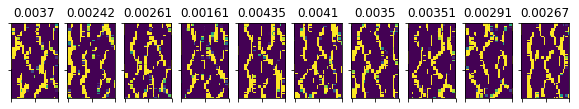

204 3.0782375 0.22107126.20636864


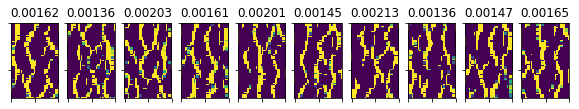

205 3.0847063 0.21065377


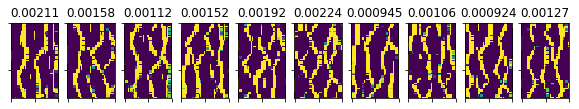

206 2.9200017 0.20631652


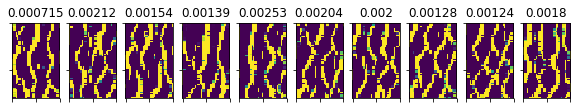

207 3.1512992 0.21898163.0678177 0.216333720.2189816


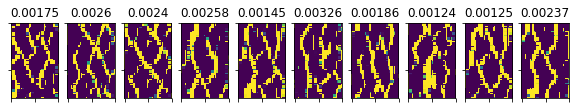

208 2.9993198 0.21658286.21821906


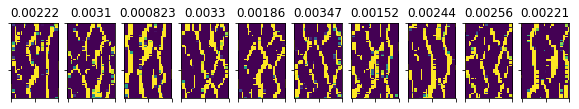

209 3.0831752 0.21537043


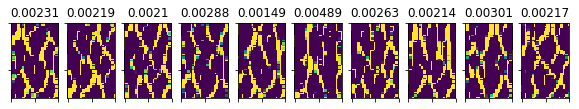

210 3.0007539 0.2202678


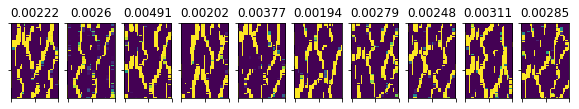

211 2.866781 0.217317280.21636465


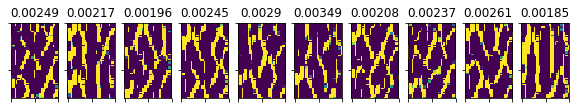

2123.0120692 0.22085577 3.0120692 0.22085577


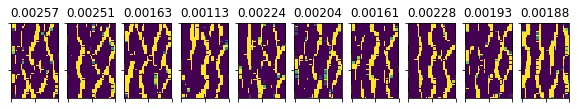

213 2.6605392 0.22845504


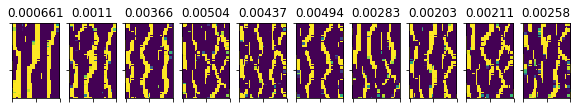

214 2.937576 0.210624190.21568044


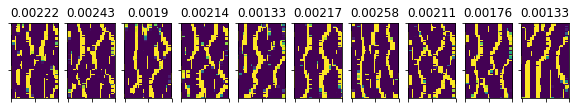

215 3.0793765 0.21097101


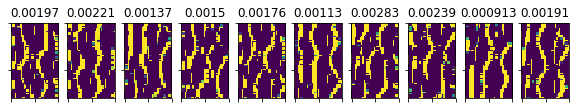

216 3.0009081 0.21375921


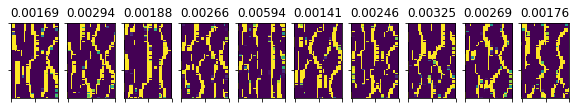

217 2.8016853 0.2127751


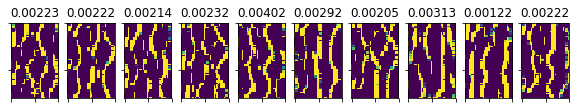

218 2.807141 0.218702630.21582390.21992871


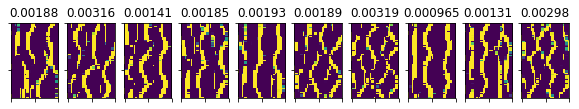

219 3.0854213 0.22167462.22365184


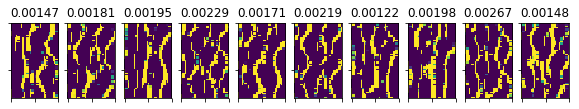

220 2.981939 0.20691335


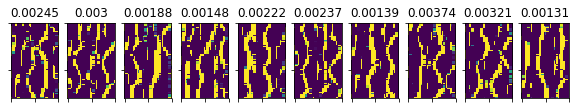

2212.9839342 0.216100280.21159972 2.9839342 0.21610028


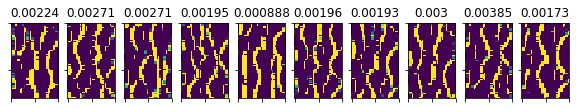

222 3.1387467 0.2200322316861 0.210170183.0518336 0.21817204


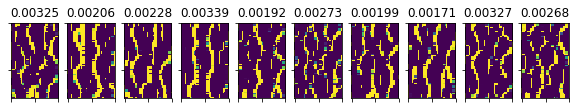

223 2.8335373 0.21196154


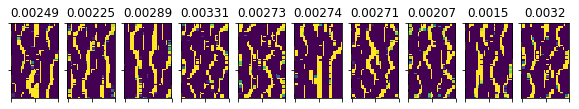

224 3.0521562 0.22160491.21881032


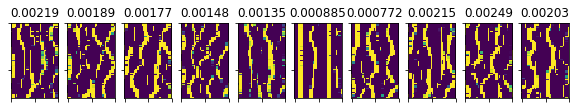

2252.7876167 0.215994820.21308176 2.7876167 0.2159948


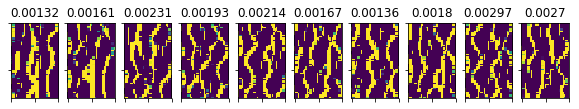

226 2.8900838 0.22411875


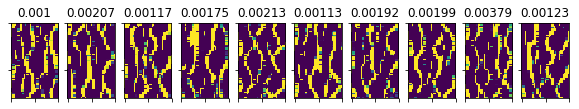

227 3.1159441 0.21689099.21802929


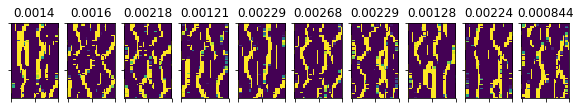

228 2.86185 0.222852166 2.9982038 0.2126031 0.2169947


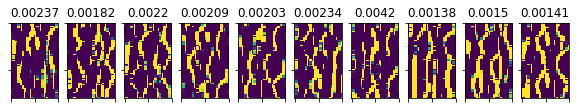

229 2.8807201 0.2028457


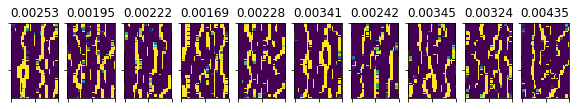

230 3.0312138 0.20374449


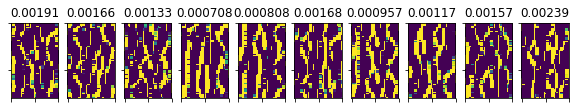

231 3.0390236 0.21895672


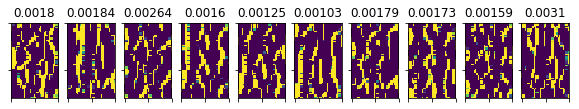

232 2.9072204 0.21255688


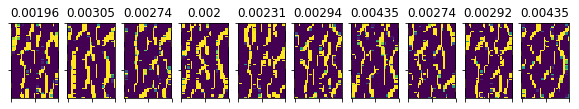

233 2.8881433 0.22026478


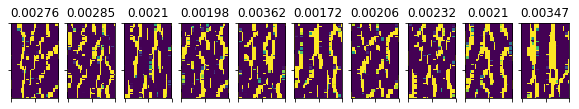

234 2.8128593 0.2049456


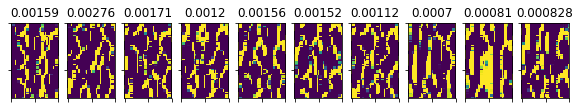

235 3.0896053 0.21211907


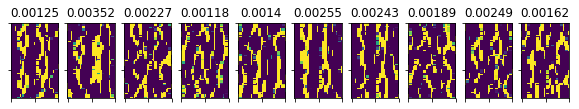

236 3.0726213 0.21212338


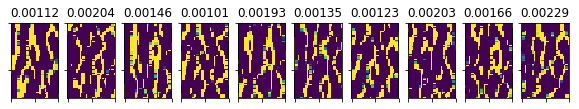

237 3.0923948 0.21941428.21082193


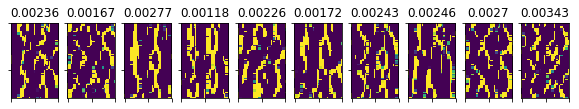

238 2.8929977 0.21841197.22131054


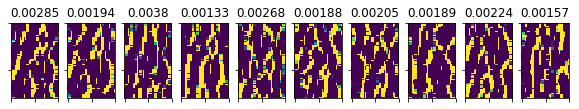

239 3.1504614 0.21945235.21854231


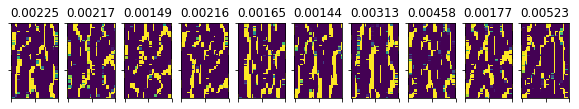

240 2.9187477 0.22233368


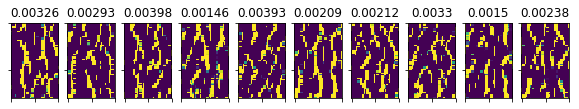

241 2.814412 0.212979420.22567543


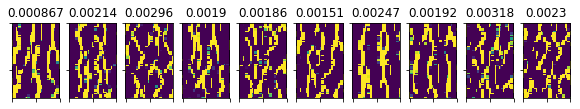

242 2.9890003 0.2137635


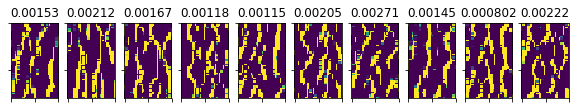

243 2.8969102 0.21537122.22617632


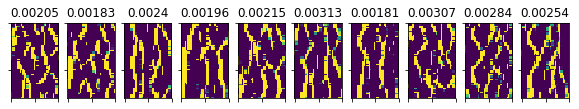

244 2.8583155 0.21056722.22499272


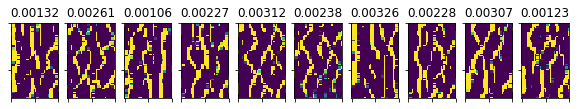

245 2.96408 0.219937123


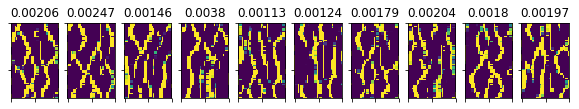

246 2.9904761 0.21222097.21115541


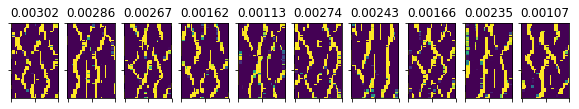

247 3.107941 0.21693581


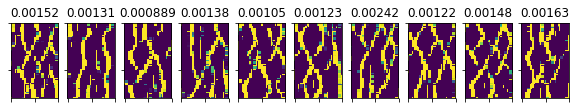

248 3.1645598 0.21674508


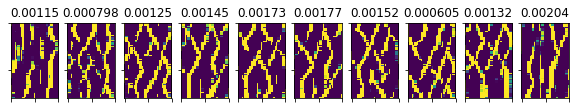

249 2.9811792 0.22172002.20773491


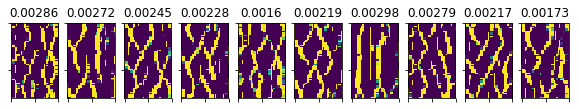

250 2.9151678 0.20828587.20789805


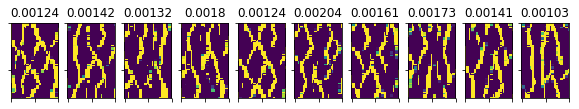

251 3.009222 0.22152112


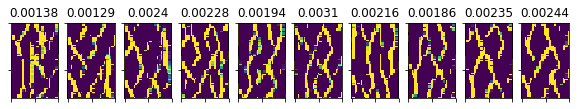

2523.0648904 0.19649613 3.0648904 0.19649613


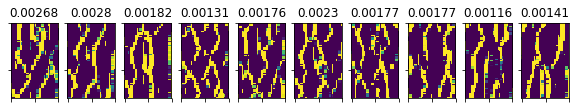

253 2.9026966 0.2178604


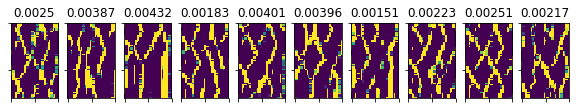

254 3.1129718 0.20219788


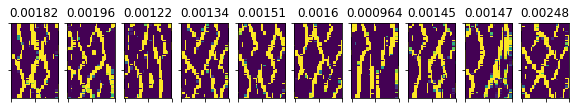

255 3.0219393 0.21484452.8683715 0.21937211


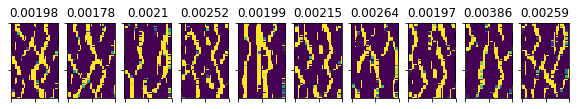

256 2.9680908 0.20942074


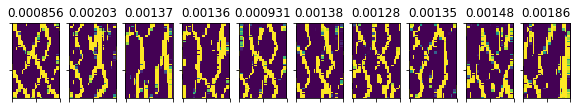

257 2.9299679 0.2143064


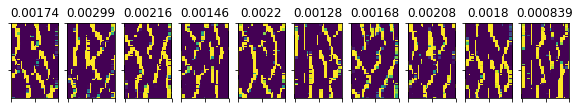

258 2.9333682 0.21421573.867483 0.21435991


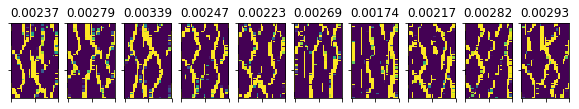

259 3.0027177 0.22845747


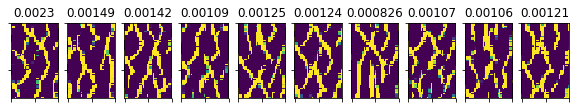

260 3.0697527 0.20888147


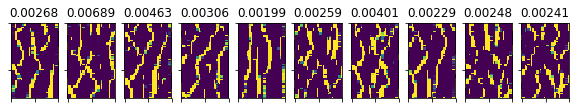

261 3.0184727 0.21949483


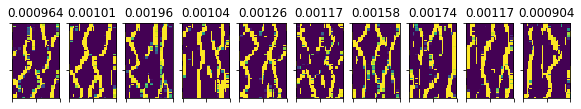

262 2.936686 0.21780881


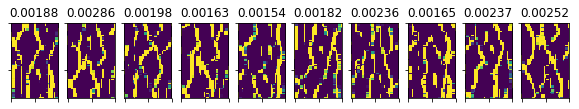

263 2.980941 0.22020076


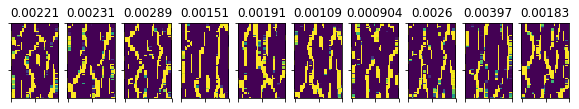

264 2.8501678 0.20770931


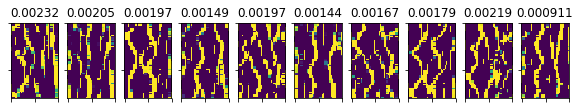

265 3.0046077 0.21992779.21938133


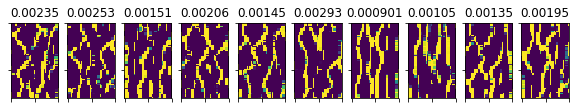

266 2.987053 0.21964225


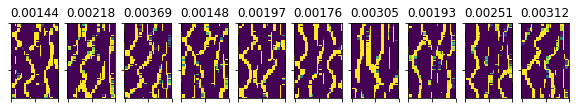

267 2.9697955 0.22197548.22201271


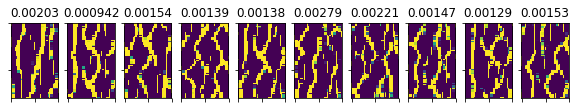

268 3.1145692 0.21903192


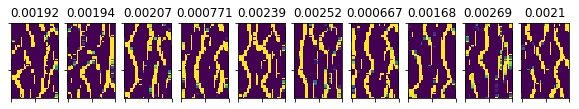

269 2.9429505 0.2195806


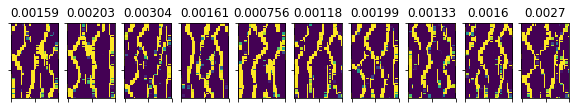

270 2.968929 0.21708709.0419614 0.22350526


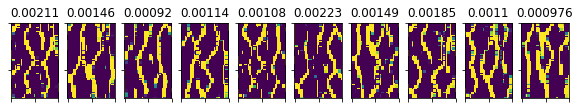

271 3.0782244 0.20976135.20717406


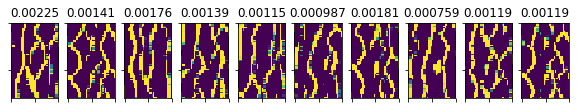

272 3.0013428 0.22576998.22386141


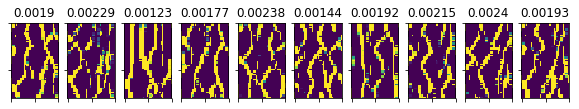

273 2.798239 0.21597835


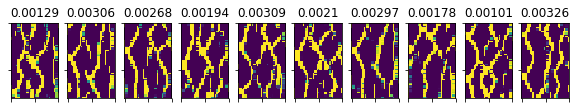

274 2.9523058 0.21255985


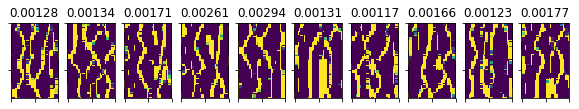

275 2.7909036 0.21718493.21702267


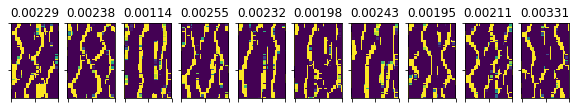

276 2.891526 0.21722373


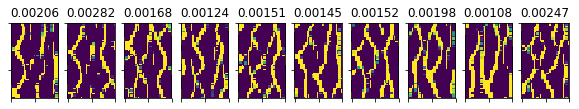

277 2.9780746 0.21454592835383 0.21096677


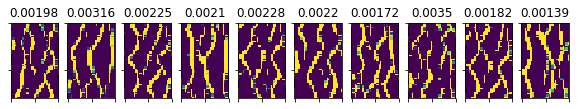

278 3.0217967 0.21082671


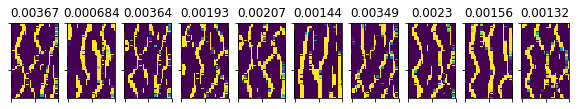

279 2.9591951 0.21479101


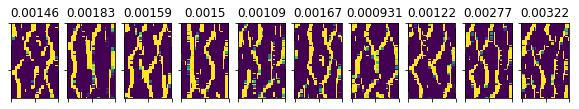

280 3.0179634 0.2110489.21763921


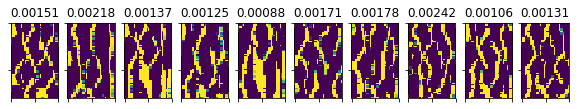

281 3.1784625 0.21774343


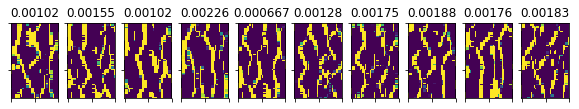

282 2.8407288 0.20779777


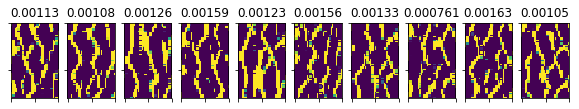

283 2.8599625 0.21775901.8460338 0.19877292


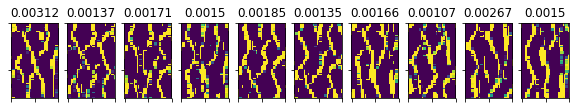

2842.923641 0.222437415 2.923641 0.22243741


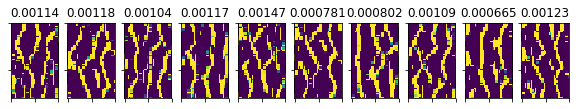

2852.9644115 0.21545163 2.9644115 0.21545163


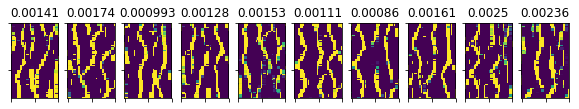

286 3.018322 0.21943079


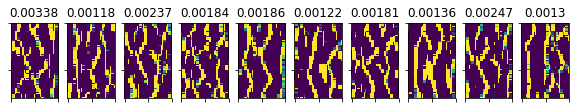

287 3.0421813 0.21723127


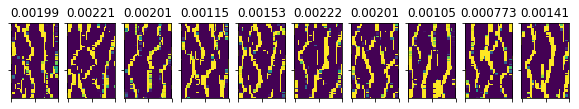

288 3.257 0.21437885583


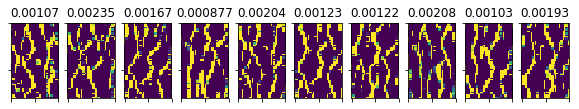

289 2.670114 0.22754952


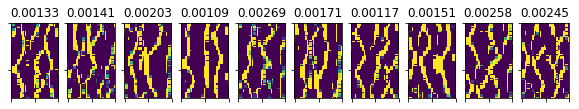

290 3.112401 0.21021334


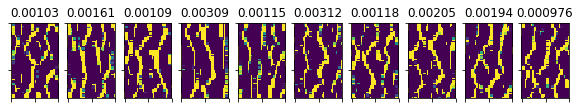

291 3.0563245 0.21094538


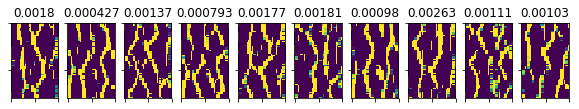

292 2.9773715 0.20705989


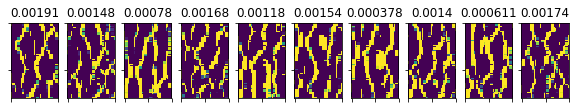

293 2.9416122 0.21893667


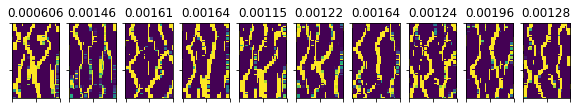

2942.9532285 0.21088763 2.9532285 0.21088763


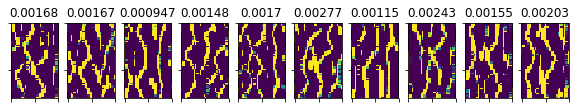

295 2.9139686 0.204915510.21323091


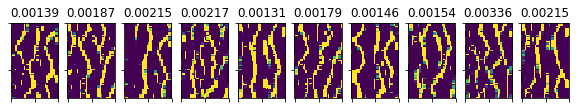

296 3.1371875 0.20498684


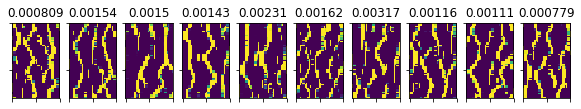

297 2.8610916 0.2108392


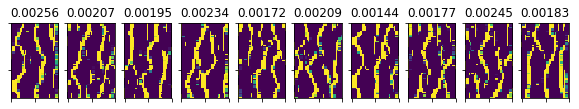

298 2.9527888 0.20753247


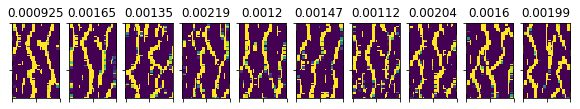

299 3.0080683 0.22005008


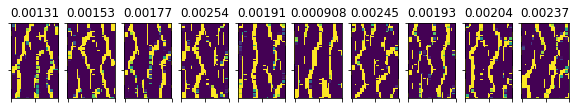

300 3.1125388 0.21637952


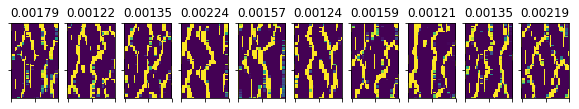

301 2.884447 0.22513554


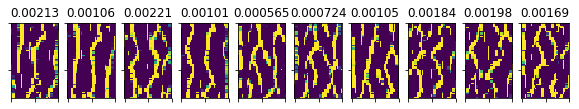

302 2.89634 0.219855597


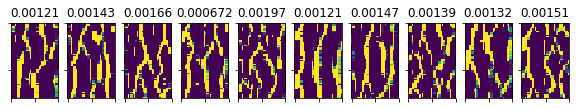

303 2.9489527 0.21582948


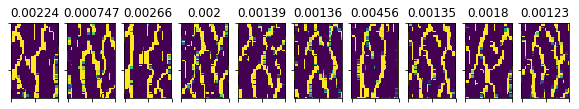

304 2.9991868 0.22588834


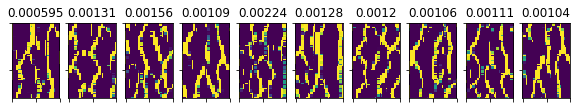

305 2.9756756 0.212988232272134


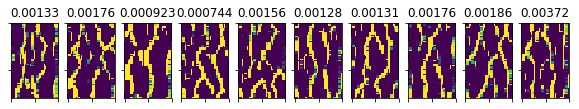

InternalError: GPU sync failed

In [13]:
batch_size = 256
assert batch_size % 2 == 0
half_batch_size = int(batch_size / 2)
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
gloss,dloss,gavg,davg = [],[],[],[]
for e in range(5):
    for bc in range(batch_count):
        noise = np.random.randn(half_batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=half_batch_size)]
        gen_im = generator.predict(noise)
        tr_im_batch = np.resize(tr_im_batch,(half_batch_size,1,nrow,ncol))
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels and flipped labels...
        tr_im_lab = np.zeros(batch_size)
        if False:#np.random.rand(1) <= 0.025:
            tr_im_lab[half_batch_size:] = np.random.uniform(0.9,1.0,size=half_batch_size)
            tr_im_lab[:half_batch_size] = np.random.uniform(0.0,0.1,size=half_batch_size)
        else:
            tr_im_lab[:half_batch_size] = np.random.uniform(0.9,1.0,size=half_batch_size)
            tr_im_lab[half_batch_size:] = np.random.uniform(0.0,0.1,size=half_batch_size)
        if True:# bc % 5 == 0:
            discriminator.trainable = True
            dl = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gl = gan.train_on_batch(noise,tr_img_lab)
        print(bc,gl,dl,end="\r")
        gavg.append(gl)
        davg.append(dl)
    gloss.append(np.array(gavg).mean())
    dloss.append(np.array(davg).mean())
    if e % 1 == 0:
        print(e,gl,dl)
        plot_gen()
        plt.show()
        
    if e % 10 ==0:
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))

In [ ]:
plt.plot(gloss)

In [ ]:
plt.plot(dloss)